<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/google_colab_examples/dssat_spatial_crop_simulation_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to perform a spatial crop simulation at a pixel-scale resolution using the WeatherSoilDataProcessor library and the DSSAT model. It covers downloading necessary spatial data (weather and soil), creating data cubes, and running the crop model simulation.

In [ ]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

import os
os.chdir('/content/WeatherSoilDataProcessor')

!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

In [1]:
!pip install hvplot panel param geoviews bokeh jupyter_bokeh -U
from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.7.3

# Run Spatial Crop Simulation at Pixel-Scale Resolution

This example demonstrates how to simulate the potential yield of a specific crop at a fine spatial resolution (250m), aligning with the SoilGrids project resolution. The simulation requires detailed information on soil and weather conditions, as well as specified management practices.

## Repository Structure

The repository is organized into three main components:

1. [**Download Spatial Data:**](#downloaddata)  
   - Weather Data
   - Soil Data

2. [**Data Cube Creation:**](#datacube)
   - Set configuration parameters
   - Spatial visualization
   - Export data as NetCDF files

3. [**Crop Modeling Using the DSSAT Model:**](#cropmodel)
   - Configuration file setup
   - Running DSSAT
   - Plotting the results

## 1. Download Spatial Data<a id="downloaddata"></a>


### Weather Data

In this section, we will download historical weather data. The information will be downloaded mainly from two sources: [CHIRPS](https://www.chc.ucsb.edu/data/chirps) and [AgERA5](https://cds.climate.copernicus.eu/datasets/sis-agrometeorological-indicators?tab=overview).

To access AgERA5 data, users must provide account credentials. This requires two key pieces of information:

- Email: The email address used to register the AgERA5 account.
- API Code: A unique code available in the profile settings after account creation.

The following command is used to authenticate and access AgERA5 data:

In [2]:
YOURUSERAPICODE = '06d3e721-5caf-4603-87ce-4a20dac9b6aa'#
YOUREMAIL = 'andres.aguilar@cgiar.org'

with open("/root/.cdsapirc", "w") as f:
  f.write("url: https://cds.climate.copernicus.eu/api\nkey: {}\nemail: ".format(YOURUSERAPICODE, YOUREMAIL))

Afterward, we set the configuration dictionary that defines the parameters for the weather data download, such as the time period, geographical extent, and the output folder path.

In [4]:
import os
os.chdir('/content/WeatherSoilDataProcessor')

import geopandas as gpd
from omegaconf import OmegaConf

from spatialdata.climate_data import MLTWeatherDataCube, ClimateDataDownload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {
    'DATES': {
        'starting_date':'2000-01-01',
        'ending_date': '2019-12-31'},
    'SPATIAL_INFO': {
          'spatial_file': None,
          'extent': None
    },
    'WEATHER': { ## weather information
        'variables': { # variables to download
              'precipitation': {'mission': 'chirps', 'source': 'chirps'},
              'solar_radiation': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmax': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmin': {'mission': 'agera5', 'source': 'agera5'}
        },
    },
    'GENERAL': {
        'suffix': "mwi",   # ISO3 code
        'ncores': 0,
    },
    'PATHS':{
        'output_path': 'weather/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': None, 'extent': None}

In [5]:
import requests

if config.SPATIAL_INFO.get('spatial_file',None):
  extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), round_numbers = True)
elif config.GENERAL.get('suffix', None):
  country = config.GENERAL.suffix.upper()
  boundary_type = 'ADM0'
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{boundary_type}/"
  meta = requests.get(url).json()
  extent = get_boundaries_from_path(meta["gjDownloadURL"], round_numbers = True)

else:
    extent = config.SPATIAL_INFO.extent

print(f"from {config.DATES.starting_date} to {config.DATES.ending_date}" )
climatedata = ClimateDataDownload(starting_date= config.DATES.starting_date,
                                    ending_date= config.DATES.ending_date,
                                    xyxy= extent,
                                    output_folder= config.PATHS.output_path)

climatedata.download_weather_information(config.WEATHER.variables, suffix_output_folder=config.GENERAL.suffix, ncores = config.GENERAL.ncores)

Streaming output truncated to the last 5000 lines.
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.04.26.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.04.27.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.04.28.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.04.29.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.04.30.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.05.01.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.05.02.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.05.03.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2006/chirps-v2.0.2006.05.04.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/glo

2025-09-30 14:41:33,918 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:41:33,922 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:41:34,234 INFO Request ID is c8287307-9354-4057-8850-0b19fd88890f
INFO:ecmwf.datastores.legacy_client:Request ID is c8287307-9354-4057-8850-0b19fd88890f
2025-09-30 14:41:34,362 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to a

572bd4e8d96330f2837df514a35e5ae2.zip:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

2025-09-30 14:41:48,808 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:41:48,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2000 to weather/solar_radiation_mwi_raw/2000.zip
Requesting data for year 2001 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2001'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:41:49,006 INFO Request ID is d82437a0-325a-4a1f-a286-3f66aa7c37ab
INFO:ecmwf.datastores.legacy_client:Request ID is d82437a0-325a-4a1f-a286-3f66aa7c37ab
2025-09-30 14:41:49,061 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:41:57,380 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:42:02,488 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


129eb139a559efb72af7089748f48385.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:42:03,278 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:42:03,280 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2001 to weather/solar_radiation_mwi_raw/2001.zip
Requesting data for year 2002 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2002'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:42:03,417 INFO Request ID is ce0931ce-c550-4fe0-959f-33875f1754ff
INFO:ecmwf.datastores.legacy_client:Request ID is ce0931ce-c550-4fe0-959f-33875f1754ff
2025-09-30 14:42:03,462 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:42:17,089 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:42:24,725 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


c9c4d4dbf482c4973b3595c240dcbf79.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:42:25,492 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:42:25,494 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2002 to weather/solar_radiation_mwi_raw/2002.zip
Requesting data for year 2003 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2003'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:42:25,722 INFO Request ID is 1a894940-015b-44a0-87d7-0206a2c1a3a9
INFO:ecmwf.datastores.legacy_client:Request ID is 1a894940-015b-44a0-87d7-0206a2c1a3a9
2025-09-30 14:42:25,776 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:42:39,375 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


17844abd3ee2c40e1644322e7da73f5.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Successfully downloaded data for year 2003 to weather/solar_radiation_mwi_raw/2003.zip
Requesting data for year 2004 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2004'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:42:40,654 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:42:40,656 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:42:40,830 INFO Request ID is 9330ece8-160e-4497-9d64-293227849ad9
INFO:ecmwf.datastores.legacy_client:Request ID is 9330ece8-160e-4497-9d64-293227849ad9
2025-09-30 14:42:40,879 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to a

7fe30c569ff39fac04e54c5566eea715.zip:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

2025-09-30 14:42:55,508 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:42:55,510 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2004 to weather/solar_radiation_mwi_raw/2004.zip
Requesting data for year 2005 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2005'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:42:55,663 INFO Request ID is 0f2b51c3-3269-4f27-aedc-7b8763ccb00a
INFO:ecmwf.datastores.legacy_client:Request ID is 0f2b51c3-3269-4f27-aedc-7b8763ccb00a
2025-09-30 14:42:56,249 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:43:09,958 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


55c8fe6c18e3bb6aea4f8ef98e418964.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:43:10,665 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:43:10,667 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2005 to weather/solar_radiation_mwi_raw/2005.zip
Requesting data for year 2006 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2006'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:43:10,819 INFO Request ID is b095a5c2-cc6e-4fac-b075-9800cc6d8e41
INFO:ecmwf.datastores.legacy_client:Request ID is b095a5c2-cc6e-4fac-b075-9800cc6d8e41
2025-09-30 14:43:10,880 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:43:19,188 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:43:24,297 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f1d4212c48e2fe052a749b80e89d9f7d.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:43:25,113 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:43:25,115 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2006 to weather/solar_radiation_mwi_raw/2006.zip
Requesting data for year 2007 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2007'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:43:25,313 INFO Request ID is 6730f958-a93f-4958-ab0b-6894d053210f
INFO:ecmwf.datastores.legacy_client:Request ID is 6730f958-a93f-4958-ab0b-6894d053210f
2025-09-30 14:43:25,366 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:43:38,923 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


29630785861f05d60dee6a54960d7a6a.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Successfully downloaded data for year 2007 to weather/solar_radiation_mwi_raw/2007.zip
Requesting data for year 2008 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2008'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:43:39,868 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:43:39,870 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:43:40,156 INFO Request ID is a01fe240-b4d5-4600-9527-74419a2f938e
INFO:ecmwf.datastores.legacy_client:Request ID is a01fe240-b4d5-4600-9527-74419a2f938e
2025-09-30 14:43:40,259 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to a

f082998787a5ece2eaf112e46dcca5fc.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:43:55,127 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:43:55,129 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2008 to weather/solar_radiation_mwi_raw/2008.zip
Requesting data for year 2009 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2009'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:43:55,369 INFO Request ID is 070fbec8-8c48-439f-ab29-70431f47c8e7
INFO:ecmwf.datastores.legacy_client:Request ID is 070fbec8-8c48-439f-ab29-70431f47c8e7
2025-09-30 14:43:55,430 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:44:03,782 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:44:08,895 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


1ae5292a3619c0993c08075f1ea5472a.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:44:09,945 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:44:09,948 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2009 to weather/solar_radiation_mwi_raw/2009.zip
Requesting data for year 2010 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2010'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:44:10,116 INFO Request ID is e8a5d529-bee6-442b-8fc4-63dc6173de92
INFO:ecmwf.datastores.legacy_client:Request ID is e8a5d529-bee6-442b-8fc4-63dc6173de92
2025-09-30 14:44:10,179 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:44:23,736 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


69a93eee1c4e39f1b2c4f877013d0859.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:44:24,717 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:44:24,720 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2010 to weather/solar_radiation_mwi_raw/2010.zip
Requesting data for year 2011 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2011'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:44:25,389 INFO Request ID is 7c56ea18-76c3-40f7-a7b4-b7a2265df5eb
INFO:ecmwf.datastores.legacy_client:Request ID is 7c56ea18-76c3-40f7-a7b4-b7a2265df5eb
2025-09-30 14:44:25,447 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:44:33,934 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


d825ad4012af9514504368648e259bb8.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:44:34,797 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:44:34,800 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2011 to weather/solar_radiation_mwi_raw/2011.zip
Requesting data for year 2012 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2012'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:44:35,493 INFO Request ID is cb3b1031-f41e-446a-bdfb-56a3587fe834
INFO:ecmwf.datastores.legacy_client:Request ID is cb3b1031-f41e-446a-bdfb-56a3587fe834
2025-09-30 14:44:35,545 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:44:44,395 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:44:57,170 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


4a18170eb49f689dd8db3f3aeb9d3336.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:44:57,960 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:44:57,962 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2012 to weather/solar_radiation_mwi_raw/2012.zip
Requesting data for year 2013 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2013'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:44:58,185 INFO Request ID is c9d07088-736f-4c0c-a32c-a9b4f30a43fb
INFO:ecmwf.datastores.legacy_client:Request ID is c9d07088-736f-4c0c-a32c-a9b4f30a43fb
2025-09-30 14:44:58,362 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:45:11,882 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a0c12cb6bc39cda57b91915f5ee06eda.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Successfully downloaded data for year 2013 to weather/solar_radiation_mwi_raw/2013.zip
Requesting data for year 2014 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2014'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:45:12,810 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:45:12,814 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:45:13,071 INFO Request ID is 29bb7b82-2602-4009-9a75-122d7b2c3258
INFO:ecmwf.datastores.legacy_client:Request ID is 29bb7b82-2602-4009-9a75-122d7b2c3258
2025-09-30 14:45:13,117 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to a

6176a890ef870a7e8312b9ef97ba8cc.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:45:35,077 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:45:35,079 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2014 to weather/solar_radiation_mwi_raw/2014.zip
Requesting data for year 2015 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2015'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:45:35,486 INFO Request ID is 70d17441-a5a4-4912-b515-08dcbd294005
INFO:ecmwf.datastores.legacy_client:Request ID is 70d17441-a5a4-4912-b515-08dcbd294005
2025-09-30 14:45:35,656 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:45:43,992 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


60ad1923243c0987e6399172b90d36d4.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:45:44,794 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:45:44,797 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2015 to weather/solar_radiation_mwi_raw/2015.zip
Requesting data for year 2016 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2016'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:45:44,986 INFO Request ID is 80392e1b-f7b6-4d52-bc4d-f30817d2855d
INFO:ecmwf.datastores.legacy_client:Request ID is 80392e1b-f7b6-4d52-bc4d-f30817d2855d
2025-09-30 14:45:45,134 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:45:58,626 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:46:17,942 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


8b2c0f9339cba40c2b8b807484ee240a.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:46:19,286 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:46:19,288 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2016 to weather/solar_radiation_mwi_raw/2016.zip
Requesting data for year 2017 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2017'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:46:19,615 INFO Request ID is 5f53f0ff-802f-4710-9573-7d1f3425e47c
INFO:ecmwf.datastores.legacy_client:Request ID is 5f53f0ff-802f-4710-9573-7d1f3425e47c
2025-09-30 14:46:19,692 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:46:28,046 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9a91b93b2d0393060b2b46c1d20372fd.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:46:29,264 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:46:29,267 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2017 to weather/solar_radiation_mwi_raw/2017.zip
Requesting data for year 2018 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2018'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:46:29,425 INFO Request ID is 9abd3d51-78c4-4d53-9868-6f9eee9e0dad
INFO:ecmwf.datastores.legacy_client:Request ID is 9abd3d51-78c4-4d53-9868-6f9eee9e0dad
2025-09-30 14:46:29,667 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:46:38,413 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:46:43,559 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


e566b9392d396477130f8375e46f1d9.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:46:46,169 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:46:46,172 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2018 to weather/solar_radiation_mwi_raw/2018.zip
Requesting data for year 2019 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['solar_radiation_flux'], 'year': ['2019'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:46:47,702 INFO Request ID is 72614831-c965-4bc5-bcef-c0d936f389be
INFO:ecmwf.datastores.legacy_client:Request ID is 72614831-c965-4bc5-bcef-c0d936f389be
2025-09-30 14:46:47,745 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:47:01,284 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


5bb02fd0c9360d6a53900f1b71301abd.zip:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

2025-09-30 14:47:02,163 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:47:02,165 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2019 to weather/solar_radiation_mwi_raw/2019.zip
Requesting data for year 2000 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2000'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:47:02,309 INFO Request ID is e6640e4c-ad3e-4326-97fd-14aeabc99610
INFO:ecmwf.datastores.legacy_client:Request ID is e6640e4c-ad3e-4326-97fd-14aeabc99610
2025-09-30 14:47:02,355 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:47:11,179 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


68b24153cc12d08be688f62196a83d1c.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:47:11,986 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:47:11,989 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2000 to weather/temperature_tmax_mwi_raw/2000.zip
Requesting data for year 2001 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2001'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:47:12,147 INFO Request ID is e748baf2-ec64-46a7-92e8-6a7c3d8df1c0
INFO:ecmwf.datastores.legacy_client:Request ID is e748baf2-ec64-46a7-92e8-6a7c3d8df1c0
2025-09-30 14:47:12,204 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:47:26,264 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ac0e0d133023512febff8c0fae6c8d54.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:47:27,139 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:47:27,142 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2001 to weather/temperature_tmax_mwi_raw/2001.zip
Requesting data for year 2002 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2002'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:47:27,358 INFO Request ID is 1aef560b-8c33-4321-9332-7a89a17e73f7
INFO:ecmwf.datastores.legacy_client:Request ID is 1aef560b-8c33-4321-9332-7a89a17e73f7
2025-09-30 14:47:27,412 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:47:35,749 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:47:40,870 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


53d31011e91dc99f6c1415185124e3bb.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:47:42,247 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:47:42,251 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2002 to weather/temperature_tmax_mwi_raw/2002.zip
Requesting data for year 2003 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2003'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:47:42,384 INFO Request ID is 6c817b89-5e37-4d84-801e-44d3aa37f926
INFO:ecmwf.datastores.legacy_client:Request ID is 6c817b89-5e37-4d84-801e-44d3aa37f926
2025-09-30 14:47:42,434 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:47:56,250 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:48:03,888 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a39c692ac31159b2799f28c11f37c218.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:48:05,347 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:48:05,351 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2003 to weather/temperature_tmax_mwi_raw/2003.zip
Requesting data for year 2004 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2004'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:48:05,673 INFO Request ID is 2eb931d7-1e79-447e-9f25-48fe3583c562
INFO:ecmwf.datastores.legacy_client:Request ID is 2eb931d7-1e79-447e-9f25-48fe3583c562
2025-09-30 14:48:05,720 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:48:26,907 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b17d70ae22cb1f1e4a40fa766e94fc2.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:48:27,705 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:48:27,708 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2004 to weather/temperature_tmax_mwi_raw/2004.zip
Requesting data for year 2005 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2005'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:48:28,098 INFO Request ID is 25787a60-7c8d-4da0-8ad5-473125b93d80
INFO:ecmwf.datastores.legacy_client:Request ID is 25787a60-7c8d-4da0-8ad5-473125b93d80
2025-09-30 14:48:28,149 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:48:36,452 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:48:41,557 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


e2f1bf3a819f5d5ba58f382ac47be42f.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:48:42,387 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:48:42,389 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2005 to weather/temperature_tmax_mwi_raw/2005.zip
Requesting data for year 2006 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2006'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:48:42,548 INFO Request ID is 0fd7b231-f647-4016-a73f-65202ee1a760
INFO:ecmwf.datastores.legacy_client:Request ID is 0fd7b231-f647-4016-a73f-65202ee1a760
2025-09-30 14:48:42,863 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:48:56,270 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


5944c01e5e25e6f6c62d82ee394893d.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:48:57,076 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:48:57,078 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2006 to weather/temperature_tmax_mwi_raw/2006.zip
Requesting data for year 2007 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2007'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:48:57,256 INFO Request ID is df947818-a3bc-45d2-b5a7-01d2a0a0f23d
INFO:ecmwf.datastores.legacy_client:Request ID is df947818-a3bc-45d2-b5a7-01d2a0a0f23d
2025-09-30 14:48:57,420 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:49:05,758 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:49:10,878 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b541dedd887cfad69936492232cec072.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:49:11,956 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:49:11,959 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2007 to weather/temperature_tmax_mwi_raw/2007.zip
Requesting data for year 2008 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2008'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:49:12,324 INFO Request ID is 543fe269-82cb-4dcd-ae58-77292124e53f
INFO:ecmwf.datastores.legacy_client:Request ID is 543fe269-82cb-4dcd-ae58-77292124e53f
2025-09-30 14:49:12,382 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:49:26,128 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


7e701d054940c8d8a9e72fce93135689.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:49:26,965 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:49:26,968 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2008 to weather/temperature_tmax_mwi_raw/2008.zip
Requesting data for year 2009 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2009'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:49:27,120 INFO Request ID is e391e4b6-f688-4e91-8e39-9bc9e080827a
INFO:ecmwf.datastores.legacy_client:Request ID is e391e4b6-f688-4e91-8e39-9bc9e080827a
2025-09-30 14:49:27,165 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:49:35,474 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:49:40,581 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a6b491cd44fda148a9b2fe7c14402b36.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:49:42,932 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:49:42,934 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2009 to weather/temperature_tmax_mwi_raw/2009.zip
Requesting data for year 2010 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2010'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:49:43,113 INFO Request ID is cce36ff0-0016-4a47-92f7-4b2114f8960e
INFO:ecmwf.datastores.legacy_client:Request ID is cce36ff0-0016-4a47-92f7-4b2114f8960e
2025-09-30 14:49:43,184 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:50:04,390 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


c51360ef2570a094a9f69f10682daab0.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:50:05,189 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:50:05,191 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2010 to weather/temperature_tmax_mwi_raw/2010.zip
Requesting data for year 2011 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2011'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:50:05,492 INFO Request ID is 8f4f5206-e73b-4742-9d99-84d6515881c3
INFO:ecmwf.datastores.legacy_client:Request ID is 8f4f5206-e73b-4742-9d99-84d6515881c3
2025-09-30 14:50:05,577 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:50:14,477 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b0d7679962a476417e4da613d4bff8bd.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:50:16,403 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:50:16,405 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2011 to weather/temperature_tmax_mwi_raw/2011.zip
Requesting data for year 2012 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2012'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:50:16,587 INFO Request ID is a707adcd-ac87-487d-9b63-1977bb7da72a
INFO:ecmwf.datastores.legacy_client:Request ID is a707adcd-ac87-487d-9b63-1977bb7da72a
2025-09-30 14:50:16,819 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:50:30,608 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


94eb0e3e570f2cd133ff597e13b951.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:50:32,243 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:50:32,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2012 to weather/temperature_tmax_mwi_raw/2012.zip
Requesting data for year 2013 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2013'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:50:32,611 INFO Request ID is a6aab98c-3d19-41a8-afb6-3383d536d436
INFO:ecmwf.datastores.legacy_client:Request ID is a6aab98c-3d19-41a8-afb6-3383d536d436
2025-09-30 14:50:32,647 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:50:46,068 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f6ba6202004861f9981ae79d094eab17.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:50:46,887 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:50:46,890 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2013 to weather/temperature_tmax_mwi_raw/2013.zip
Requesting data for year 2014 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2014'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:50:47,178 INFO Request ID is 6100809a-a720-4226-b701-7d8de05c0a09
INFO:ecmwf.datastores.legacy_client:Request ID is 6100809a-a720-4226-b701-7d8de05c0a09
2025-09-30 14:50:47,243 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:50:57,249 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:51:02,373 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


4b16d5e1d0f6e4b905a782ed631d2695.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:51:03,078 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:51:03,080 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2014 to weather/temperature_tmax_mwi_raw/2014.zip
Requesting data for year 2015 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2015'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:51:03,250 INFO Request ID is 5c1e7340-7b2a-4051-884c-6ad3f4429dfe
INFO:ecmwf.datastores.legacy_client:Request ID is 5c1e7340-7b2a-4051-884c-6ad3f4429dfe
2025-09-30 14:51:03,478 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:51:18,144 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cbc2fa2eded8a79b93afd4dbaa735612.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:51:19,639 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:51:19,641 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2015 to weather/temperature_tmax_mwi_raw/2015.zip
Requesting data for year 2016 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2016'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:51:19,808 INFO Request ID is 331d40e5-729d-4d45-9eee-261ff1424c68
INFO:ecmwf.datastores.legacy_client:Request ID is 331d40e5-729d-4d45-9eee-261ff1424c68
2025-09-30 14:51:19,874 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:51:40,978 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2100e6ef5d64980ef7b74c9d16b94ed5.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:51:43,436 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:51:43,440 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2016 to weather/temperature_tmax_mwi_raw/2016.zip
Requesting data for year 2017 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2017'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:51:43,589 INFO Request ID is c1c07c92-81d7-4a74-9781-2addf66aa31b
INFO:ecmwf.datastores.legacy_client:Request ID is c1c07c92-81d7-4a74-9781-2addf66aa31b
2025-09-30 14:51:43,637 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:52:05,346 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2a47422595179dc60dc841f7a15d5c93.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:52:06,061 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:52:06,063 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2017 to weather/temperature_tmax_mwi_raw/2017.zip
Requesting data for year 2018 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2018'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:52:06,255 INFO Request ID is b8104e69-5a59-49e3-9a6f-ac1dd5692487
INFO:ecmwf.datastores.legacy_client:Request ID is b8104e69-5a59-49e3-9a6f-ac1dd5692487
2025-09-30 14:52:06,444 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:52:15,067 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:52:20,195 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


333a8db42a9174b76bdf616c900e4951.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:52:21,015 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:52:21,017 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2018 to weather/temperature_tmax_mwi_raw/2018.zip
Requesting data for year 2019 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2019'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:52:21,605 INFO Request ID is a3b1e355-3313-413f-a051-2d403da153c0
INFO:ecmwf.datastores.legacy_client:Request ID is a3b1e355-3313-413f-a051-2d403da153c0
2025-09-30 14:52:21,680 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:52:35,152 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:52:42,791 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


4a99aca3578dec24a7df7b0256131cdf.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:52:43,623 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:52:43,625 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2019 to weather/temperature_tmax_mwi_raw/2019.zip
Requesting data for year 2000 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2000'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:52:43,768 INFO Request ID is eaa8d781-b0ea-465c-b72a-3defa38b46e8
INFO:ecmwf.datastores.legacy_client:Request ID is eaa8d781-b0ea-465c-b72a-3defa38b46e8
2025-09-30 14:52:43,807 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:52:52,423 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:52:57,531 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


db79b2b31c6cff0b55e1e24a661fd0a2.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:52:58,238 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:52:58,240 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2000 to weather/temperature_tmin_mwi_raw/2000.zip
Requesting data for year 2001 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2001'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:52:58,357 INFO Request ID is 11dfd9e4-bca0-4356-8a90-1affd8a51587
INFO:ecmwf.datastores.legacy_client:Request ID is 11dfd9e4-bca0-4356-8a90-1affd8a51587
2025-09-30 14:52:58,401 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:53:19,468 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:53:32,384 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f2bae37323a9bf47c6a0061861ce1737.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:53:33,152 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:53:33,155 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2001 to weather/temperature_tmin_mwi_raw/2001.zip
Requesting data for year 2002 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2002'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:53:33,323 INFO Request ID is a718f7cd-0bed-4b93-b20c-540919966fe5
INFO:ecmwf.datastores.legacy_client:Request ID is a718f7cd-0bed-4b93-b20c-540919966fe5
2025-09-30 14:53:33,401 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:53:41,717 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


5333049cdd3c09f584fdb11af8d16a62.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:53:42,650 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:53:42,653 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2002 to weather/temperature_tmin_mwi_raw/2002.zip
Requesting data for year 2003 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2003'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:53:42,825 INFO Request ID is 4a220bb5-a53a-4e33-8e5a-ed538f593298
INFO:ecmwf.datastores.legacy_client:Request ID is 4a220bb5-a53a-4e33-8e5a-ed538f593298
2025-09-30 14:53:42,875 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:53:51,820 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f7cc56c0a77e1b92c792a29e471327e4.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:53:52,777 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


Successfully downloaded data for year 2003 to weather/temperature_tmin_mwi_raw/2003.zip
Requesting data for year 2004 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2004'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:53:52,779 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:53:52,953 INFO Request ID is 01e55155-319e-4127-82a5-2770bb19bb64
INFO:ecmwf.datastores.legacy_client:Request ID is 01e55155-319e-4127-82a5-2770bb19bb64
2025-09-30 14:53:53,002 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:54:04,401 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


dd87525c6f3efa41bc2e415b064ee61b.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:54:05,225 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:54:05,227 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2004 to weather/temperature_tmin_mwi_raw/2004.zip
Requesting data for year 2005 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2005'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:54:05,403 INFO Request ID is 3850f0fc-b868-4e99-9b0f-33e3a4dfe247
INFO:ecmwf.datastores.legacy_client:Request ID is 3850f0fc-b868-4e99-9b0f-33e3a4dfe247
2025-09-30 14:54:05,464 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:54:15,475 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9878b891aa5ca5f9ac23b23655ed6e2b.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:54:16,286 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:54:16,289 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2005 to weather/temperature_tmin_mwi_raw/2005.zip
Requesting data for year 2006 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2006'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:54:16,494 INFO Request ID is 6471d4be-db4b-4c76-9b9c-f742c96d8e8d
INFO:ecmwf.datastores.legacy_client:Request ID is 6471d4be-db4b-4c76-9b9c-f742c96d8e8d
2025-09-30 14:54:16,538 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:54:24,838 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:54:29,944 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9f6fd7612e25e13534e0c7fd84b897d6.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:54:32,602 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:54:32,604 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2006 to weather/temperature_tmin_mwi_raw/2006.zip
Requesting data for year 2007 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2007'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:54:32,772 INFO Request ID is 10a8f6d3-899f-4d1f-9f4f-54657eacd00e
INFO:ecmwf.datastores.legacy_client:Request ID is 10a8f6d3-899f-4d1f-9f4f-54657eacd00e
2025-09-30 14:54:32,823 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:54:46,282 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:54:53,933 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


3a8118c85d942a20b2a6658ec7f2fabe.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:54:54,624 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:54:54,626 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2007 to weather/temperature_tmin_mwi_raw/2007.zip
Requesting data for year 2008 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2008'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:54:54,803 INFO Request ID is ee1a54d4-145a-4e51-ae79-fa04c68cf36b
INFO:ecmwf.datastores.legacy_client:Request ID is ee1a54d4-145a-4e51-ae79-fa04c68cf36b
2025-09-30 14:54:54,881 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:55:08,464 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:55:16,148 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cfcdcf4543110d38a5f49ac34021887e.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:55:16,934 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:55:16,936 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2008 to weather/temperature_tmin_mwi_raw/2008.zip
Requesting data for year 2009 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2009'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:55:17,155 INFO Request ID is 8ab29706-ebe3-4eff-a700-e366f4784dae
INFO:ecmwf.datastores.legacy_client:Request ID is 8ab29706-ebe3-4eff-a700-e366f4784dae
2025-09-30 14:55:17,302 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:55:30,737 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ab849608db21400b7056b10977455ae7.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:55:31,471 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:55:31,474 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2009 to weather/temperature_tmin_mwi_raw/2009.zip
Requesting data for year 2010 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2010'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:55:31,614 INFO Request ID is 7dc36bc9-be92-417d-8dda-aa86e81d0b04
INFO:ecmwf.datastores.legacy_client:Request ID is 7dc36bc9-be92-417d-8dda-aa86e81d0b04
2025-09-30 14:55:31,663 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:55:40,548 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:55:45,671 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:56:04,871 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


aca182f486eff9c71557c1eb50f4fb3a.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:56:05,690 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:56:05,693 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2010 to weather/temperature_tmin_mwi_raw/2010.zip
Requesting data for year 2011 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2011'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:56:05,948 INFO Request ID is d02965ca-d010-4283-abd7-d9fbe37069b1
INFO:ecmwf.datastores.legacy_client:Request ID is d02965ca-d010-4283-abd7-d9fbe37069b1
2025-09-30 14:56:06,371 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:56:19,884 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b72a4f74ef87e5e4f49bf0c5d724bd41.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:56:20,650 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:56:20,652 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2011 to weather/temperature_tmin_mwi_raw/2011.zip
Requesting data for year 2012 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2012'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:56:21,927 INFO Request ID is a37cf468-60a6-4e45-9f82-1f0da4814321
INFO:ecmwf.datastores.legacy_client:Request ID is a37cf468-60a6-4e45-9f82-1f0da4814321
2025-09-30 14:56:21,974 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:57:13,630 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cba3c4c44323d57bdf5650cf153e341e.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

Successfully downloaded data for year 2012 to weather/temperature_tmin_mwi_raw/2012.zip
Requesting data for year 2013 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2013'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:57:14,543 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:57:14,545 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:57:14,692 INFO Request ID is f072ee48-0901-43a7-9fb0-5042066494aa
INFO:ecmwf.datastores.legacy_client:Request ID is f072ee48-0901-43a7-9fb0-5042066494aa
2025-09-30 14:57:14,754 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to a

f6a0f5d4c7eaf9a4b3f40d0a15b2b9a3.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:57:25,690 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:57:25,692 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2013 to weather/temperature_tmin_mwi_raw/2013.zip
Requesting data for year 2014 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2014'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:57:26,139 INFO Request ID is 3460b7e5-d4a3-46b6-b0bf-acb523b6334d
INFO:ecmwf.datastores.legacy_client:Request ID is 3460b7e5-d4a3-46b6-b0bf-acb523b6334d
2025-09-30 14:57:26,200 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:57:31,527 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-30 14:57:34,963 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


6a9cb0f55ef39c9da3674cbad992a130.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:57:35,786 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:57:35,790 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2014 to weather/temperature_tmin_mwi_raw/2014.zip
Requesting data for year 2015 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2015'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:57:36,012 INFO Request ID is d7a41115-09f8-4dd5-b8aa-287b0d0e9166
INFO:ecmwf.datastores.legacy_client:Request ID is d7a41115-09f8-4dd5-b8aa-287b0d0e9166
2025-09-30 14:57:36,077 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:57:44,396 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


1fc7bc5bb3974827758524239366ffb4.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

Successfully downloaded data for year 2015 to weather/temperature_tmin_mwi_raw/2015.zip
Requesting data for year 2016 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2016'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:57:45,350 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:57:45,353 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-30 14:57:45,597 INFO Request ID is 21ef4e29-7795-4404-b7b8-c40e63afc205
INFO:ecmwf.datastores.legacy_client:Request ID is 21ef4e29-7795-4404-b7b8-c40e63afc205
2025-09-30 14:57:45,645 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to a

453cb4edab681f6c7070eddba37c5856.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:58:00,111 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:58:00,113 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2016 to weather/temperature_tmin_mwi_raw/2016.zip
Requesting data for year 2017 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2017'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:58:00,322 INFO Request ID is 0addf59d-a08c-4aad-b528-cf7b7ca2521a
INFO:ecmwf.datastores.legacy_client:Request ID is 0addf59d-a08c-4aad-b528-cf7b7ca2521a
2025-09-30 14:58:00,364 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:58:14,672 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


bede7173ba2519df93db8dfd40d409e1.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:58:15,695 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:58:15,697 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2017 to weather/temperature_tmin_mwi_raw/2017.zip
Requesting data for year 2018 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2018'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:58:16,006 INFO Request ID is 820aaa71-95bb-4a1a-9aea-ac35ac48d83d
INFO:ecmwf.datastores.legacy_client:Request ID is 820aaa71-95bb-4a1a-9aea-ac35ac48d83d
2025-09-30 14:58:16,060 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:58:29,503 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


41ee2438bbe29d27f4254f188d3ff94b.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

2025-09-30 14:58:30,296 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 14:58:30,300 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Successfully downloaded data for year 2018 to weather/temperature_tmin_mwi_raw/2018.zip
Requesting data for year 2019 with query: {'version': '2_0', 'area': [-9, 32, -18, 36], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2019'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-09-30 14:58:30,550 INFO Request ID is c96683da-b154-463b-9f41-cad58b5f9b4e
INFO:ecmwf.datastores.legacy_client:Request ID is c96683da-b154-463b-9f41-cad58b5f9b4e
2025-09-30 14:58:30,601 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-30 14:58:44,033 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


14079ab6cd9ca8c398c2dc1ff27011dd.zip:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

Successfully downloaded data for year 2019 to weather/temperature_tmin_mwi_raw/2019.zip


### Soil Data

In this section, we will download soil data information for different depths. Currently, the information is downloaded from the [SoilGrids](https://soilgrids.org/) project. SoilGrids provides global gridded soil information at a resolution of 250 meters. The data includes various soil properties at different depths, which are crucial inputs for crop modeling.

In [7]:
from spatialdata.soil_data import SoilGridDataDonwload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {

    'SPATIAL_INFO': {
          'spatial_file': None,
          'extent': None,
          'crs': 'ESRI:54052' ## soilgrids projection system
    },
    'SOIL': {
          'variables': ["clay",  "sand", "silt", "cec", "bdod", "cfvo", "nitrogen", "phh2o", "soc","wv0010","wv0033", "wv1500"],
          'depths': ["0-5","5-15","15-30","30-60"]
    },
    'GENERAL': {
        'suffix': 'mwi'   # ISO3 country code
    },
    'PATHS':{
        'output_path': 'soil/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': None, 'extent': None, 'crs': 'ESRI:54052'}

In [8]:

if config.SPATIAL_INFO.get('spatial_file',None):
  extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), crs = config.SPATIAL_INFO.crs, round_numbers = True)
elif config.GENERAL.get('suffix', None):
  country = config.GENERAL.suffix.upper()
  boundary_type = 'ADM0'
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{boundary_type}/"
  meta = requests.get(url).json()
  extent = get_boundaries_from_path(meta["gjDownloadURL"],crs = config.SPATIAL_INFO.crs, round_numbers = True)

else:
    extent = config.SPATIAL_INFO.extent


outputpath = os.path.join(config.PATHS.output_path, config.GENERAL.suffix)

soildata = SoilGridDataDonwload(soil_layers= config.SOIL.variables,
                            depths= config.SOIL.depths,
                            output_folder= outputpath)

soildata.download_soilgrid(boundaries= extent)

## 2. Data Cube Creation<a id="datacube"></a>

### Set configuration parameters
To implement this, it is necessary to have spatial information for soil and climate. We can create a datacube with dimensions height, width, channel, and date for weather, and height, width, channel, and depth for soil.

An example of the spatial configuration is available in the options folder. Here, we will define it as a dictionary variable.

In [6]:
import warnings
import requests
# To ignore all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
## Configuration for creating spatial data cubes
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialData

configuration_info = {
    'GENERAL_INFO': {
        'projected_crs':'ESRI:54052',  # Projected Coordinate System for spatial data
        'suffix': 'mwi'  # Suffix used for output files, ISO3 country code
    },
    'SPATIAL_VECTOR': {
        # 'boundaries': "data/country.shp", # Optional: Path to a geospatial file defining spatial boundaries
        'boundaries': None  # Set to None to download boundaries based on country code
    },
    'WEATHER': {  # Weather data configuration
        'setup_parameters': {  # Parameters for creating the weather data cube
            'paths':{  # Paths to raw meteorological variable data
                'precipitation': "weather/precipitation_hnd_raw",
                'srad': "weather/solar_radiation_hnd_raw",
                'tmax': "weather/temperature_tmax_hnd_raw",
                'tmin': "weather/temperature_tmin_hnd_raw"
            },
            'crs': 'EPSG:4326',  # Spatial Coordinate System for weather data
            'period': ['2000-01-01', '2019-12-31'] ,  # Time period for weather data
            'reference_variable': 'precipitation'  # Variable used as spatial resolution reference
        },
        'data_cube_path' : None  # Optional: Path to an existing weather data cube NetCDF file
    },
    'SOIL': {  # Soil data configuration
        'setup_parameters': {  # Parameters for creating the soil data cube
            'path': "soil/hnd/",  # Path to raw soil data
            'variables': ["clay",  "sand", "silt", "cec", "bdod", "cfvo", "nitrogen", "phh2o", "soc","wv0010","wv0033", "wv1500"],  # Soil variables to include
            'depths': ["0-5","5-15","15-30","30-60"],  # Soil depths to include
            'crs': 'ESRI:54052',  # Spatial Coordinate System for SoilGrids data
            'reference_variable': 'sand'  # Variable used as spatial resolution reference
        },
        'data_cube_path' : None  # Optional: Path to an existing soil data cube NetCDF file
    }
}

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
## creating boundaries file if there is not one
import geopandas as gpd
if configuration_info['SPATIAL_VECTOR'].get('boundaries', None) is None:
  country = configuration_info['GENERAL_INFO']['suffix'].upper()
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/ADM0/"
  meta = requests.get(url).json()
  data_country = gpd.read_file(meta["gjDownloadURL"])
  cs = configuration_info['GENERAL_INFO']['suffix'] = configuration_info['GENERAL_INFO']['suffix']
  data_country.to_file(f'data/country_{cs}.shp')
  configuration_info['SPATIAL_VECTOR']['boundaries'] = f'data/country_{cs}.shp'
  print(cs)
  configuration_info['WEATHER']['setup_parameters']['paths']['precipitation'] = f"weather/precipitation_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['srad'] = f"weather/solar_radiation_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['tmax'] = f"weather/temperature_tmax_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['tmin'] = f"weather/temperature_tmin_{cs}_raw"
  configuration_info['SOIL']['setup_parameters']['path'] = f"soil/{cs}"


mwi


In [ ]:

# Initialize SpatialData with the configuration dictionary
spdata = SpatialData(configuration_dict=configuration_info)

# Retrieve climate data
spdata.get_climate_data()


weather/precipitation_mwi_raw/2000
weather/precipitation_mwi_raw/2001
weather/precipitation_mwi_raw/2002
weather/precipitation_mwi_raw/2003
weather/precipitation_mwi_raw/2004
weather/precipitation_mwi_raw/2005
weather/precipitation_mwi_raw/2006
weather/precipitation_mwi_raw/2007
weather/precipitation_mwi_raw/2008
weather/precipitation_mwi_raw/2009
weather/precipitation_mwi_raw/2010
weather/precipitation_mwi_raw/2011
weather/precipitation_mwi_raw/2012
weather/precipitation_mwi_raw/2013
weather/precipitation_mwi_raw/2014
weather/precipitation_mwi_raw/2015
weather/precipitation_mwi_raw/2016
weather/precipitation_mwi_raw/2017
weather/precipitation_mwi_raw/2018
weather/precipitation_mwi_raw/2019
weather/solar_radiation_mwi_raw/2000
weather/solar_radiation_mwi_raw/2001
weather/solar_radiation_mwi_raw/2002
weather/solar_radiation_mwi_raw/2003
weather/solar_radiation_mwi_raw/2004
weather/solar_radiation_mwi_raw/2005
weather/solar_radiation_mwi_raw/2006
weather/solar_radiation_mwi_raw/2007
weat

 44%|████▍     | 3246/7305 [06:32<07:16,  9.31it/s]

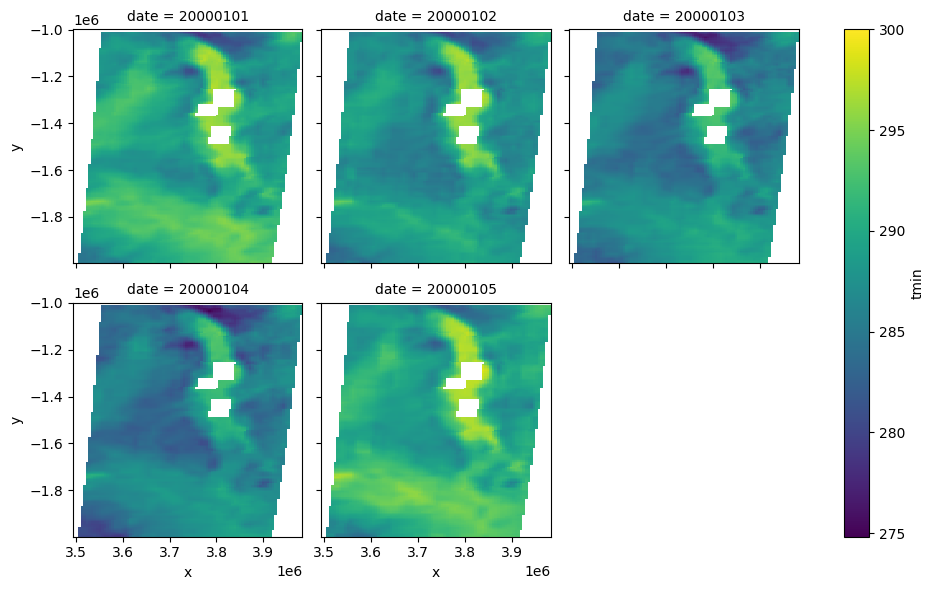

In [7]:
## plots

g_simple = spdata.climate.tmin.isel(date = list(range(5))).plot(x="x", y="y", col="date", col_wrap=3, vmax = 300)

In [8]:
spdata._save_asnc(spdata.climate, fn = f'weather/weather_{cs}.nc')

In [9]:
spdata.climate = None

100%|██████████| 4/4 [01:48<00:00, 27.23s/it]


PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]

100%|██████████| 4/4 [00:00<00:00, 426.10it/s]


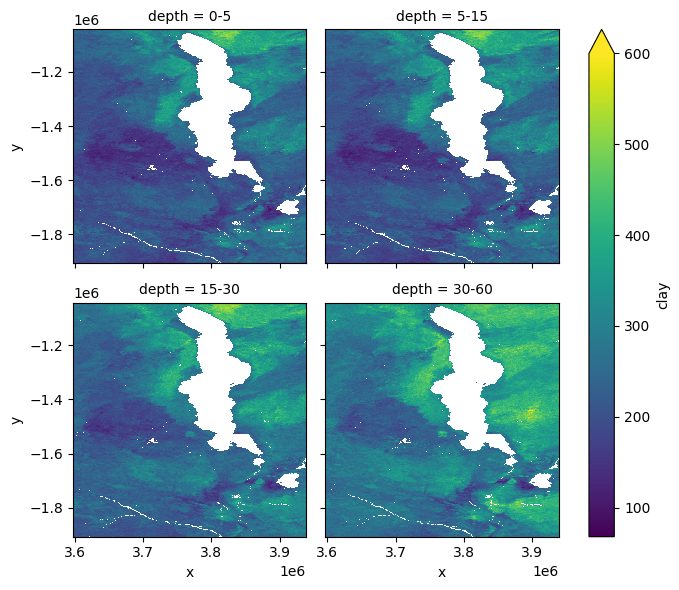

In [10]:

# Retrieve soil data
spdata.get_soil_data()

# texture values in soil grids data is multiply by 10
g_simple = spdata.soil.clay.plot(x="x", y="y", col="depth", col_wrap=2, vmax = 600)

In [11]:
# save data as datacubes
spdata._save_asnc(spdata.soil, fn = f'soil/soil_{cs}.nc')


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import shutil

source_folder = '/content/WeatherSoilDataProcessor/weather/weather_mwi.nc'
destination_folder = '/content/drive/MyDrive/CIAT'

shutil.copy2(source_folder, destination_folder)

source_folder = '/content/WeatherSoilDataProcessor/soil/soil_mwi.nc'
destination_folder = '/content/drive/MyDrive/CIAT'
shutil.copy2(source_folder, destination_folder)


'/content/drive/MyDrive/CIAT/soil_mwi.nc'

## 3. Crop Modeling Using the DSSAT Model<a id="cropmodel"></a>




### Spatial data

The previous steps serve as a guide for obtaining the spatial datacubes data, (climate, and weather). In the following example, we will use datacubes that were previously processed for the entire country. These files contain historical climate data spanning a 34-year period. They are available in a Google Drive folder, so you will only need to download them using the gdown function.


In [ ]:
import os
soil_fileid = '1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn'
weather_fileid = '1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD'

if not os.path.exists('hnd_soilgrids.nc'):
  !gdown --id {soil_fileid} --output hnd_soilgrids.nc

if not os.path.exists('hnd_weather.nc'):
  !gdown --id {weather_fileid} --output hnd_weather.nc

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn
From (redirected): https://drive.google.com/uc?id=1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn&confirm=t&uuid=30d87b91-e105-4189-94f9-2a30965f702b
To: /content/hnd_soilgrids.nc
100% 191M/191M [00:02<00:00, 76.5MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD
From (redirected): https://drive.google.com/uc?id=1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD&confirm=t&uuid=6f7b59ab-55f2-4ba9-9de5-7573d322e811
To: /content/hnd_weathe

### Configuration file setup

To specify that the analysis will be done at pixel-scale, we set 'pixel' in the configuration dictionary.

Other parameters to configure include crop parameters and management practices.
Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.

In [ ]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialCM
import numpy as np
import pandas as pd

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 15,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': '/content/WeatherSoilDataProcessor/data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'pixel',
        'soil_path' : '/content/hnd_soilgrids.nc',
        'weather_path': '/content/hnd_weather.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': 'IB1072', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '1991-03-01',
        'harvesting_date': None,
        'plantingWindow': 30, # planting window in weeks
        'fertilizer_schedule': {
            'days_after_planting': None,
            'npk': None
        },
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}



/usr/local/lib/python3.11/dist-packages/DSSATTools/__init__.py:88: DeprecationWarning: DSSATTools version 3 is soon to be released. The new version is a major upgrade and will not be backwards compatible. This will be the latest release of DSSATTools version 2.
  warnings.warn(


### Running DSSAT

In [ ]:
# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)
geocode = '150149'
# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features['GEOCODIGO']==str(geocode)]
roi_name = roi[cm_sp.config.SPATIAL_INFO.feature_name].values[0]
roi
#cm_sp.geo_features['GEOCODIGO']

loaded from /content/hnd_soilgrids.nc
loaded from /content/hnd_weather.nc


,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
932,150149,Pusunca o San Agustín,150149,1501,15,20.8814,51.0981,Juticalpa,Olancho,2088.138366,"POLYGON ((-86.11061 14.70222, -86.10999 14.702..."


In [ ]:

import shutil
if os.path.exists(f'/content/WeatherSoilDataProcessor/runs/{geocode}'):
  shutil.rmtree(f'/content/WeatherSoilDataProcessor/runs/{geocode}', ignore_errors=False, onerror=None)

In [ ]:
cm_sp.set_up_folders(site = roi_name)

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    roi= roi,
    export_spatial_data= True
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    dssath_path = cm_sp.config.GENERAL_INFO.get('dssat_path', None)
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                    ncores = cm_sp.config.GENERAL_INFO.ncores,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Configuration file written: runs/150149/114/experimental_file_config.yaml
experimental file created: ['runs/150149/114/EXPS0001.MZX']
Configuration file written: runs/150149/100/experimental_file_config.yaml
experimental file created: ['runs/150149/100/EXPS0001.MZX']
Configuration file written: runs/150149/113/experimental_file_config.yaml
experimental file created: ['runs/150149/113/EXPS0001.MZX']
Configuration file written: runs/150149/93/experimental_file_config.yaml
experimental file created: ['runs/150149/93/EXPS0001.MZX']
Configuration file written: runs/150149/127/experimental_file_config.yaml
experimental file created: ['runs/150149/127/EXPS0001.MZX']
Configuration file written: runs/150149/116/experimental_file_config.yaml
experimental file created: ['runs/150149/116/EXPS0001.MZX']
Configuration file written: runs/150149/85/experimental_file_config.yaml
experimental file created: ['runs/150149/85/EXPS0001.MZX']
Configuration file written: runs/150149/111/experimental_file_conf

  2%|▏         | 1/51 [00:36<30:20, 36.41s/it]

### Crop simulation outputs

After completing the simulation, the next step is to generate the output maps.


In [ ]:
from crop_modeling.dssat.output import update_dssat_data_using_path
from crop_modeling.spatial_process import create_mlt_yield_raster
import rioxarray as rio
import matplotlib.pyplot as plt


refraster = rio.open_rasterio(os.path.join(cm_sp._tmp_path,'ref_raster.tif'))
model_data = update_dssat_data_using_path(cm_sp._tmp_path)

mlt_pot_yield = create_mlt_yield_raster(refraster, model_data, ycol_name='HWAH')


### Plotting the results

In [ ]:
import hvplot.xarray
import holoviews as hv
import panel as pn

hv.extension("bokeh")
minlim = mlt_pot_yield.HWAH.min().values
maxlim = mlt_pot_yield.HWAH.max().values

mltmap = mlt_pot_yield.HWAH.hvplot.image(x='x', y='y', groupby = 'date',frame_height = 600, frame_width= 400, cmap='YlGnBu', fontscale=1.6, crs='EPSG:4326', tiles = 'EsriImagery', clim=(minlim,maxlim))

dmap_panel = pn.panel(mltmap)
dmap_panel


### Exporting the results

In [ ]:
from crop_modeling.utils.process import get_crs_fromxarray,set_encoding, check_crs_inxrdataset

dcengine = 'netcdf4'
encoding = set_encoding(mlt_pot_yield)
xrdata = check_crs_inxrdataset(mlt_pot_yield)
xrdata.to_netcdf(f'simlations_{geocode}.nc', encoding = encoding, engine = dcengine)



In [ ]:
import hvplot.pandas
boxplot = mlt_pot_yield.HWAH.hvplot.box('HWAH', by=['date'], rot=90, box_fill_color='lightblue', width=1600, height=450).opts(ylim=(1285,9969))
dmap_panel = pn.panel(boxplot)
dmap_panel

In [ ]:
from crop_modeling.utils.output_transforms import summarize_spatial_yields_by_time_window

summ_yield  =summarize_spatial_yields_by_time_window(xrdmlt_pot_yieldata, plantingWindow= 30)
